# PK/PD AL Blood Volume and Hill Equation analyses
# Date: 07/30/2025

## 1. Studying how blood volume affects the hill equation

<br>

In [76]:
import subprocess
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolacors
import pickle
from tqdm import tqdm  # For progress bar
from multiprocessing import Pool, cpu_count
import os
import sys
import time
import datetime 
from math import *

### a. Default PD model
#### ```patient_blood_volume = weight * 70 * 1000```

#### Instantaeneous hourly killing rate ```a```

$$
(\frac{-1}{24}) \times ln({1.0} - \frac{P_{max}\times{concentration}^n}{{concentration}^n + EC_{50}^n})
$$

#### Killing fraction:
$$
\frac{P_{max}\times concentration^n}{concentration^n + EC_{50}^n}
$$

#### Hourly killing rate:
$$
(\frac{-1}{24}) \times ln({1.0} - killing fraction)
$$

#### Net hourly growth rate:

$g = 0.048$

$ net\,hourly\,growth\,rate = g - \,hourly \,killing \,rate$

#### Calculating BV using the Lemmens-Bernstein-Brodsky Equation

$$
BV = \frac{70}{\sqrt{\frac{BMI}{22}}}
$$

#### Calculating concentration using allometric scaling

$$
concentration~= \frac{dose~\times~weight^{0.75}}{weight~\times~\frac{70}{\sqrt\frac{18.5}{22}}}
$$

In [77]:
def generate_recommended_dosing_schedule(weight):
    if weight < 15.0:
        num_tablets_per_dose = 0.50
    elif weight < 25.0:
        num_tablets_per_dose = 1.0
    elif weight < 35.0:
        num_tablets_per_dose = 1.50
    else:
        num_tablets_per_dose = 2.0
    total_mg_dose_per_occassion = num_tablets_per_dose * 40.0;
    return total_mg_dose_per_occassion

In [78]:
def sigmoid_function(concentration, pmax, ec50, n):
    return (pmax * (concentration ** n)) / ((concentration ** n) + (ec50 ** n))

# Time to go ham and mess with all kind of blood volume calculations to make the concentrations similar across weights

In [79]:
70/np.sqrt(18.5/22)

np.float64(76.3349659528779)

#### Interesting... let's run the model with these parameters

In [80]:
# Generating total dose for each weight over 3 days with twice daily dosing
weight_values = list(range(5, 101, 5))  # Re-defining weight values for clarity
total_dose_mg = []

for weight in weight_values:
    total_mg_dose = generate_recommended_dosing_schedule(weight) * 6  # Assuming 3 days of treatment
    total_dose_mg.append(total_mg_dose)
for i in range(len(weight_values)):
    print(f"Total dose for weight {weight_values[i]} kg: {total_dose_mg[i]} mg")

upper_limit_mg = total_dose_mg
lower_limit_mg = [0] * len(weight_values)

lower_limit_concentration = []
upper_limit_concentration = []

for i in range(len(weight_values)):
    lower_limit_concentration.append(lower_limit_mg[i] / ((weight_values[i] ** 0.25)* (70/np.sqrt(18.5/22))))  
    upper_limit_concentration.append(upper_limit_mg[i] / ((weight_values[i] ** 0.25)* (70/np.sqrt(18.5/22))))  

artemether_concentrations_mg_ml_final = []
for i in range(len(weight_values)):
    temp_conc = np.linspace(lower_limit_concentration[i], upper_limit_concentration[i], 1000)
    artemether_concentrations_mg_ml_final.append(temp_conc)

#Convert artemether_concentrations_ng_ml_final to artemether_concentrations_mg_ml_final
artemether_concentrations_ng_ml_final = []
for i in range(len(artemether_concentrations_mg_ml_final)):
    temp_conc = artemether_concentrations_mg_ml_final[i] * (10**6)  # Convert mg/mL to ng/mL
    artemether_concentrations_ng_ml_final.append(temp_conc)

pmax = 0.99997
ec50_dose_ng = 1*(10**6)  # Convert ng/mL to ng/mg
ec50_dose_mg = 1  
n = 20
ec50_concentrations_ng = [ec50_dose_ng for weight in weight_values] # Assuming ec50 is already a concentration
ec50_concentrations_mg = [ec50_dose_mg for weight in weight_values]  # Convert ng/mL to mg/mL

print("EC50 Concentrations (ng/mL):", ec50_concentrations_ng)
print("EC50 Concentrations (mg/mL):", ec50_concentrations_mg)

Total dose for weight 5 kg: 120.0 mg
Total dose for weight 10 kg: 120.0 mg
Total dose for weight 15 kg: 240.0 mg
Total dose for weight 20 kg: 240.0 mg
Total dose for weight 25 kg: 360.0 mg
Total dose for weight 30 kg: 360.0 mg
Total dose for weight 35 kg: 480.0 mg
Total dose for weight 40 kg: 480.0 mg
Total dose for weight 45 kg: 480.0 mg
Total dose for weight 50 kg: 480.0 mg
Total dose for weight 55 kg: 480.0 mg
Total dose for weight 60 kg: 480.0 mg
Total dose for weight 65 kg: 480.0 mg
Total dose for weight 70 kg: 480.0 mg
Total dose for weight 75 kg: 480.0 mg
Total dose for weight 80 kg: 480.0 mg
Total dose for weight 85 kg: 480.0 mg
Total dose for weight 90 kg: 480.0 mg
Total dose for weight 95 kg: 480.0 mg
Total dose for weight 100 kg: 480.0 mg
EC50 Concentrations (ng/mL): [1000000, 1000000, 1000000, 1000000, 1000000, 1000000, 1000000, 1000000, 1000000, 1000000, 1000000, 1000000, 1000000, 1000000, 1000000, 1000000, 1000000, 1000000, 1000000, 1000000]
EC50 Concentrations (mg/mL): [

In [81]:
#Checking if the total dose in nanograms and milligrams are correct
for i in range(len(weight_values)):
    print(f"Total Concentration range for weight {weight_values[i]} kg is: {artemether_concentrations_ng_ml_final[i][0]} ng/mL to {artemether_concentrations_ng_ml_final[i][-1]} ng/mL")

Total Concentration range for weight 5 kg is: 0.0 ng/mL to 1051272.317940232 ng/mL
Total Concentration range for weight 10 kg is: 0.0 ng/mL to 884011.1236114044 ng/mL
Total Concentration range for weight 15 kg is: 0.0 ng/mL to 1597588.4450173106 ng/mL
Total Concentration range for weight 20 kg is: 0.0 ng/mL to 1486723.5697784766 ng/mL
Total Concentration range for weight 25 kg is: 0.0 ng/mL to 2109084.511537863 ng/mL
Total Concentration range for weight 30 kg is: 0.0 ng/mL to 2015109.5946987185 ng/mL
Total Concentration range for weight 35 kg is: 0.0 ng/mL to 2585239.066381078 ng/mL
Total Concentration range for weight 40 kg is: 0.0 ng/mL to 2500361.0405998533 ng/mL
Total Concentration range for weight 45 kg is: 0.0 ng/mL to 2427809.4230175796 ng/mL
Total Concentration range for weight 50 kg is: 0.0 ng/mL to 2364695.4736257605 ng/mL
Total Concentration range for weight 55 kg is: 0.0 ng/mL to 2309016.5660609338 ng/mL
Total Concentration range for weight 60 kg is: 0.0 ng/mL to 2259331.24

In [48]:
#Checking if the total dose in nanograms and milligrams are correct
for i in range(len(weight_values)):
    print(f"Total Concentration range for weight {weight_values[i]} kg is: {artemether_concentrations_mg_ml_final[i][0]} mg/mL to {artemether_concentrations_mg_ml_final[i][-1]} mg/mL")

Total Concentration range for weight 5 kg is: 0.0 mg/mL to 1.0512723179402321 mg/mL
Total Concentration range for weight 10 kg is: 0.0 mg/mL to 0.8840111236114044 mg/mL
Total Concentration range for weight 15 kg is: 0.0 mg/mL to 1.5975884450173106 mg/mL
Total Concentration range for weight 20 kg is: 0.0 mg/mL to 1.4867235697784766 mg/mL
Total Concentration range for weight 25 kg is: 0.0 mg/mL to 2.109084511537863 mg/mL
Total Concentration range for weight 30 kg is: 0.0 mg/mL to 2.0151095946987185 mg/mL
Total Concentration range for weight 35 kg is: 0.0 mg/mL to 2.585239066381078 mg/mL
Total Concentration range for weight 40 kg is: 0.0 mg/mL to 2.500361040599853 mg/mL
Total Concentration range for weight 45 kg is: 0.0 mg/mL to 2.4278094230175795 mg/mL
Total Concentration range for weight 50 kg is: 0.0 mg/mL to 2.3646954736257606 mg/mL
Total Concentration range for weight 55 kg is: 0.0 mg/mL to 2.309016566060934 mg/mL
Total Concentration range for weight 60 kg is: 0.0 mg/mL to 2.25933124

Text(0.5, 1.0, 'Artemether Concentration Distribution by Weight')

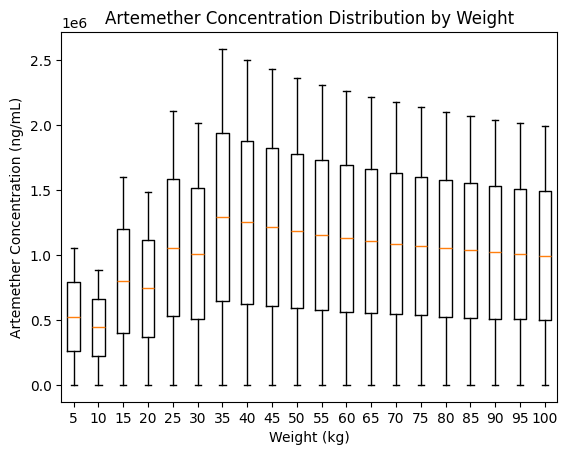

In [82]:
plt.boxplot(artemether_concentrations_ng_ml_final, tick_labels=weight_values)
plt.xlabel('Weight (kg)')
plt.ylabel('Artemether Concentration (ng/mL)')
plt.title('Artemether Concentration Distribution by Weight')

Text(0.5, 1.0, 'Artemether Concentration Distribution by Weight')

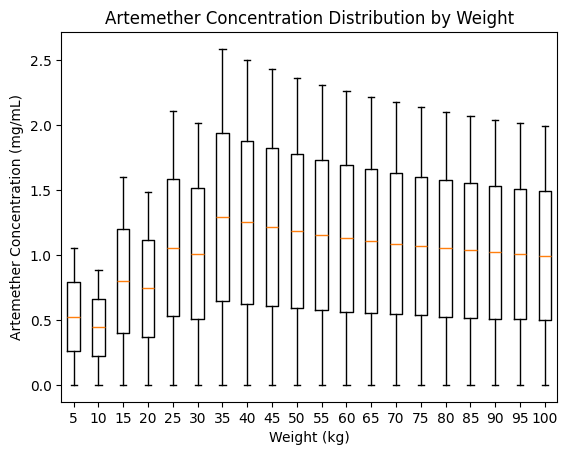

In [83]:
plt.boxplot(artemether_concentrations_mg_ml_final, tick_labels=weight_values)
plt.xlabel('Weight (kg)')
plt.ylabel('Artemether Concentration (mg/mL)')
plt.title('Artemether Concentration Distribution by Weight')

In [49]:
kill_fraction = []
killing_rates = []

for i in range(0, len(artemether_concentrations_ng_ml_final)):
    temp_kill_fraction = []
    temp_killing_rates = []
    for concentration in artemether_concentrations_ng_ml_final[i]:
        temp_kill_fraction.append(sigmoid_function(concentration, pmax, ec50_concentrations_ng[i], n))
        temp_killing_rates.append((-1/24) * np.log(1.0 - temp_kill_fraction[-1]))
    kill_fraction.append(temp_kill_fraction)
    killing_rates.append(temp_killing_rates)

growth_rate = 0.048 
effect = [] 

for i in range(len(killing_rates)):
    effect.append(growth_rate - np.array(killing_rates[i]))

kill_percent = []
for i in range(len(kill_fraction)):
    temp_kill_percent = []
    for j in range(len(kill_fraction[i])):
        temp_kill_percent.append(kill_fraction[i][j] * 100)
    kill_percent.append(temp_kill_percent)

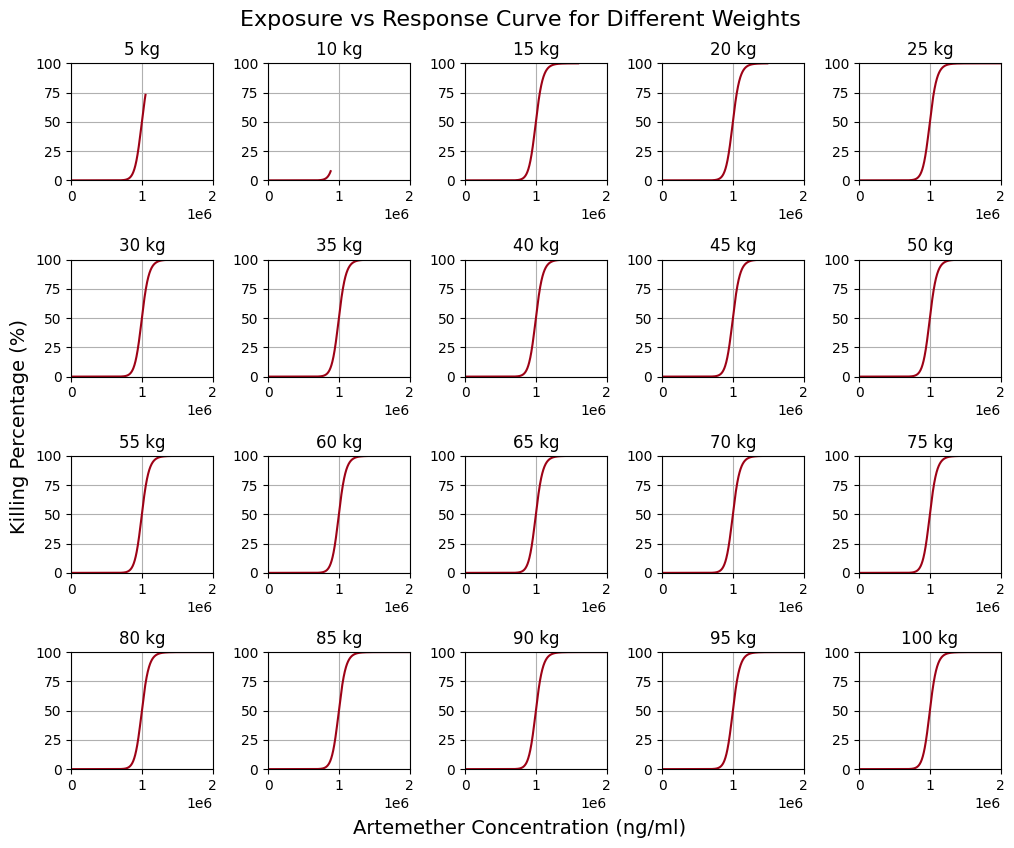

In [51]:
# Creating subplots for each weight for only killing percentage
fig, axs = plt.subplots(4, 5, figsize=(10, 8))
for i in range(len(weight_values)):
    axs[i // 5, i % 5].plot(artemether_concentrations_ng_ml_final[i], kill_percent[i], label=f'Weight: {weight_values[i]} kg', color='#9d0216')
    # axs[i // 5, i % 5].set_xlabel('Artemether Concentration (ng/ml)')
    # axs[i // 5, i % 5].set_ylabel('Killing Percentage (%)')
    axs[i // 5, i % 5].set_xlim(0, 2*10**6)  # Adjusted for ng/mL
    axs[i // 5, i % 5].set_ylim(0, 100)
    axs[i // 5, i % 5].set_title(f'{weight_values[i]} kg', fontsize=12)
    axs[i // 5, i % 5].grid()
#Setting common labels for the entire figure
fig.text(0.5, -0.01, 'Artemether Concentration (ng/ml)', ha='center', fontsize=14)
fig.text(-0.01, 0.5, 'Killing Percentage (%)', va='center', rotation='vertical', fontsize=14)
fig.text(0.5, 1.0, 'Exposure vs Response Curve for Different Weights', ha='center', fontsize=16)
plt.tight_layout()
plt.show()

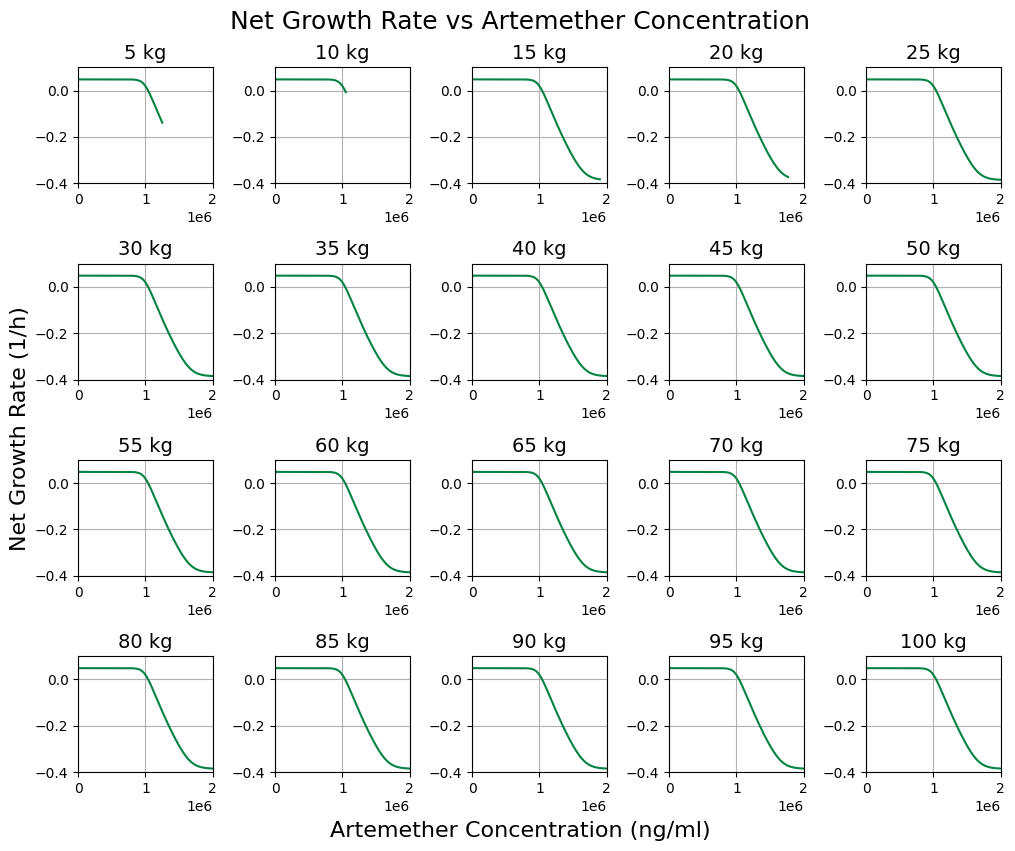

In [36]:
fig, axs = plt.subplots(4, 5, figsize=(10, 8))
for i in range(len(weight_values)):
    axs[i // 5, i % 5].plot(artemether_concentrations_ng_ml_final[i], effect[i], label=f'Weight: {weight_values[i]} kg', color="#048243")
    axs[i // 5, i % 5].set_title(f'{weight_values[i]} kg', fontsize=14)
    axs[i // 5, i % 5].set_xlim(0, 2*10**6)  # Adjusted for ng/mL
    axs[i // 5, i % 5].set_ylim(-0.4, 0.1)
    axs[i // 5, i % 5].grid()
    #axs[i // 5, i % 5].legend(loc='upper right', bbox_to_anchor=(1.25, 1))
fig.text(0.5, -0.01, 'Artemether Concentration (ng/ml)', ha='center', fontsize=16)
fig.text(-0.01, 0.5, 'Net Growth Rate (1/h)', va='center', rotation='vertical', fontsize=16)
fig.text(0.5, 1.0, 'Net Growth Rate vs Artemether Concentration', ha='center', fontsize=18)
plt.tight_layout()
plt.show()

In [52]:
kill_fraction = []
killing_rates = []

for i in range(0, len(artemether_concentrations_mg_ml_final)):
    temp_kill_fraction = []
    temp_killing_rates = []
    for concentration in artemether_concentrations_mg_ml_final[i]:
        temp_kill_fraction.append(sigmoid_function(concentration, pmax, ec50_concentrations_mg[i], n))
        temp_killing_rates.append((-1/24) * np.log(1.0 - temp_kill_fraction[-1]))
    kill_fraction.append(temp_kill_fraction)
    killing_rates.append(temp_killing_rates)

growth_rate = 0.048 
effect = [] 

for i in range(len(killing_rates)):
    effect.append(growth_rate - np.array(killing_rates[i]))

kill_percent = []
for i in range(len(kill_fraction)):
    temp_kill_percent = []
    for j in range(len(kill_fraction[i])):
        temp_kill_percent.append(kill_fraction[i][j] * 100)
    kill_percent.append(temp_kill_percent)

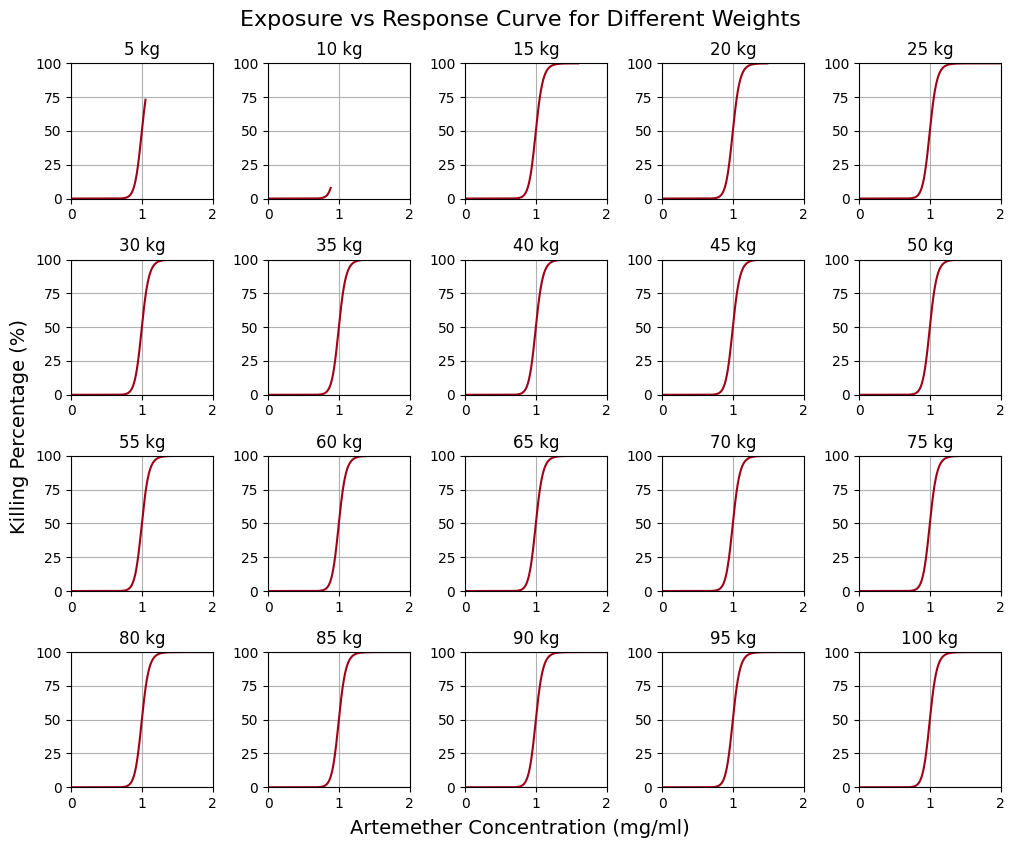

In [53]:
# Creating subplots for each weight for only killing percentage
fig, axs = plt.subplots(4, 5, figsize=(10, 8))
for i in range(len(weight_values)):
    axs[i // 5, i % 5].plot(artemether_concentrations_mg_ml_final[i], kill_percent[i], label=f'Weight: {weight_values[i]} kg', color='#9d0216')
    # axs[i // 5, i % 5].set_xlabel('Artemether Concentration (ng/ml)')
    # axs[i // 5, i % 5].set_ylabel('Killing Percentage (%)')
    axs[i // 5, i % 5].set_xlim(0, 2)  # Adjusted for mg/mL
    axs[i // 5, i % 5].set_ylim(0, 100)
    axs[i // 5, i % 5].set_title(f'{weight_values[i]} kg', fontsize=12)
    axs[i // 5, i % 5].grid()
#Setting common labels for the entire figure
fig.text(0.5, -0.01, 'Artemether Concentration (mg/ml)', ha='center', fontsize=14)
fig.text(-0.01, 0.5, 'Killing Percentage (%)', va='center', rotation='vertical', fontsize=14)
fig.text(0.5, 1.0, 'Exposure vs Response Curve for Different Weights', ha='center', fontsize=16)
plt.tight_layout()
plt.show()

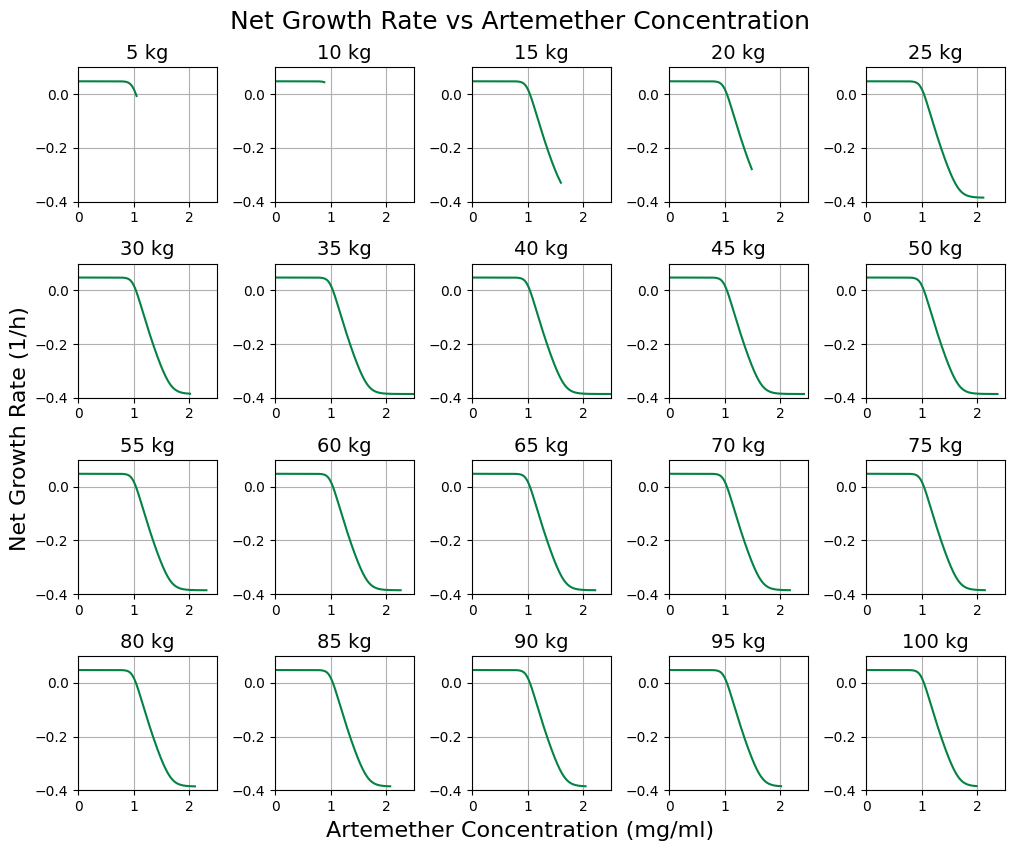

In [54]:
fig, axs = plt.subplots(4, 5, figsize=(10, 8))
for i in range(len(weight_values)):
    axs[i // 5, i % 5].plot(artemether_concentrations_mg_ml_final[i], effect[i], label=f'Weight: {weight_values[i]} kg', color="#048243")
    axs[i // 5, i % 5].set_title(f'{weight_values[i]} kg', fontsize=14)
    axs[i // 5, i % 5].set_xlim(0, 2.5)  # Adjusted for ng/mL
    axs[i // 5, i % 5].set_ylim(-0.4, 0.1)
    axs[i // 5, i % 5].grid()
    #axs[i // 5, i % 5].legend(loc='upper right', bbox_to_anchor=(1.25, 1))
fig.text(0.5, -0.01, 'Artemether Concentration (mg/ml)', ha='center', fontsize=16)
fig.text(-0.01, 0.5, 'Net Growth Rate (1/h)', va='center', rotation='vertical', fontsize=16)
fig.text(0.5, 1.0, 'Net Growth Rate vs Artemether Concentration', ha='center', fontsize=18)
plt.tight_layout()
plt.show()

In [55]:
artemether_concentrations_mg_ml_final[0]

array([0.        , 0.00105232, 0.00210465, 0.00315697, 0.0042093 ,
       0.00526162, 0.00631395, 0.00736627, 0.0084186 , 0.00947092,
       0.01052325, 0.01157557, 0.0126279 , 0.01368022, 0.01473254,
       0.01578487, 0.01683719, 0.01788952, 0.01894184, 0.01999417,
       0.02104649, 0.02209882, 0.02315114, 0.02420347, 0.02525579,
       0.02630812, 0.02736044, 0.02841277, 0.02946509, 0.03051741,
       0.03156974, 0.03262206, 0.03367439, 0.03472671, 0.03577904,
       0.03683136, 0.03788369, 0.03893601, 0.03998834, 0.04104066,
       0.04209299, 0.04314531, 0.04419763, 0.04524996, 0.04630228,
       0.04735461, 0.04840693, 0.04945926, 0.05051158, 0.05156391,
       0.05261623, 0.05366856, 0.05472088, 0.05577321, 0.05682553,
       0.05787786, 0.05893018, 0.0599825 , 0.06103483, 0.06208715,
       0.06313948, 0.0641918 , 0.06524413, 0.06629645, 0.06734878,
       0.0684011 , 0.06945343, 0.07050575, 0.07155808, 0.0726104 ,
       0.07366272, 0.07471505, 0.07576737, 0.0768197 , 0.07787